In [1]:
import sys
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras

Using TensorFlow backend.


In [2]:
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [3]:
from scipy.signal import butter, filtfilt

def butter_bandpass(data,lowcut, highcut, fs, order=5,padlen=0):
    nyq = 0.5 * fs

    low = lowcut / nyq
    high = highcut / nyq
    
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data,padlen=padlen)
    return y

In [4]:
fhcut=80     # high cut for feature vector
flcut=8      # low cut for feature vector
lhcut=300    # high cut for label vector
llcut=3      # low cut for label vector
fs=1000      # sampling freq ---> 1 ms
scMax=5000   # upper limit scale factor
scMin=-5000  # lower limit scale factor 

In [38]:
#fn='E:/PythEnv/Data/arn_near_100_hz.txt'
fn='E:/PythEnv/Data/band10203050_hz.txt'
fn2='E:/PythEnv/Data/band10203050_hz_ref.txt'

seismic = np.array(loadtxt(fn))
ref = np.array(loadtxt(fn2))
#refr=np.array(np.reshape(ref,(-1,1)))
[sz1,sz2]=ref.shape



In [29]:
 # Generate the seismic data high resolution pair
#seismic=butter_bandpass(refr,flcut, fhcut, fs, order=5)
#labels=butter_bandpass(refr,llcut, lhcut, fs, order=5)
#seismic=np.reshape(seismic,(sz1,sz2))
#labels=np.reshape(labels,(sz1,sz2))

print(seismic.shape)

(1000, 500)


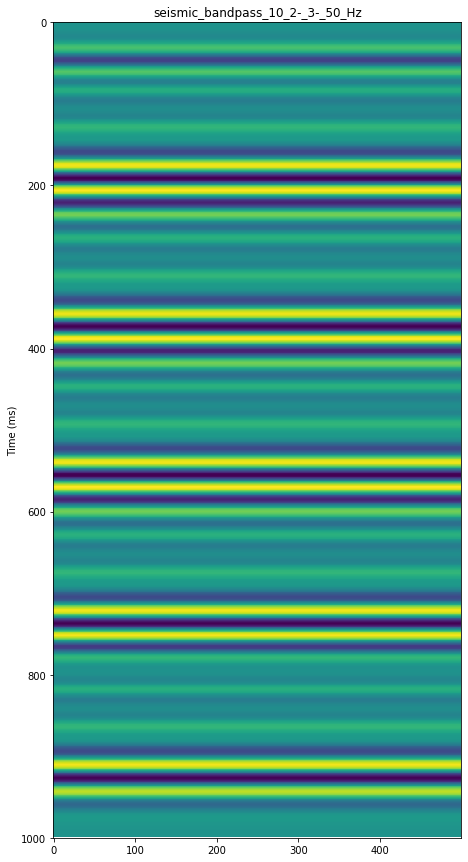

In [42]:
fig, ax1 = plt.subplots(nrows=1, ncols=1,figsize=(30, 15)) 
   
ax1.imshow(seismic)
    #ax1.imshow(ref, cmap=plt.get_cmap('gray'), vmin=0, vmax=1)
ax1.set_title('seismic_bandpass_10_2-_3-_50_Hz')
ax1.set_ylim((0,1000)[::-1])
ax1.set_ylabel('Time (ms)')
plt.show()
arnold=seismic


In [31]:
seismic=np.transpose(seismic)
seismic=scMin +(seismic-np.min(seismic))*(scMax-scMin)/(np.max(seismic)-np.min(seismic))
#labels=scMin +(labels-np.min(labels))*(scMax-scMin)/(np.max(labels)-np.min(labels))
print(seismic.shape)
seismic=np.expand_dims(seismic, axis=-1)
seismic=np.expand_dims(seismic, axis=-1)
s1,s2,s3,s4=seismic.shape

(500, 1000)


In [32]:
sys.path.append(r'E:\PythEnv')
from resnet_model_gpu import resnet_v1, lr_schedule

In [33]:
DEPTH=14
batch_size=32
epochs=2000

input_shape=(s2,s3,s4)
print(input_shape)




outmodel = resnet_v1(input_shape=input_shape,depth=DEPTH,num_classes=s2,
                 num_filters=32, nstack=4, kernel_size=(3,1), pool_size=(2,1))
outmodel.summary()

(1000, 1, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 1000, 1, 1)   0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 1000, 1, 32)  128         input_3[0][0]                    
__________________________________________________________________________________________________
activation_35 (Activation)      (None, 1000, 1, 32)  0           conv2d_43[0][0]                  
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, 1000, 1, 32)  3104        activation_35[0][0]              
________________________________________________________________________________________________

In [34]:
outmodel.load_weights('resnet_32_s4_weights.h5')

x_predm=outmodel.predict(seismic)
print(x_predm.shape)

(500, 1000, 1, 1)


In [35]:
x_pred_sm=np.transpose(np.squeeze(x_predm))
print(x_pred_sm.shape)

(1000, 500)


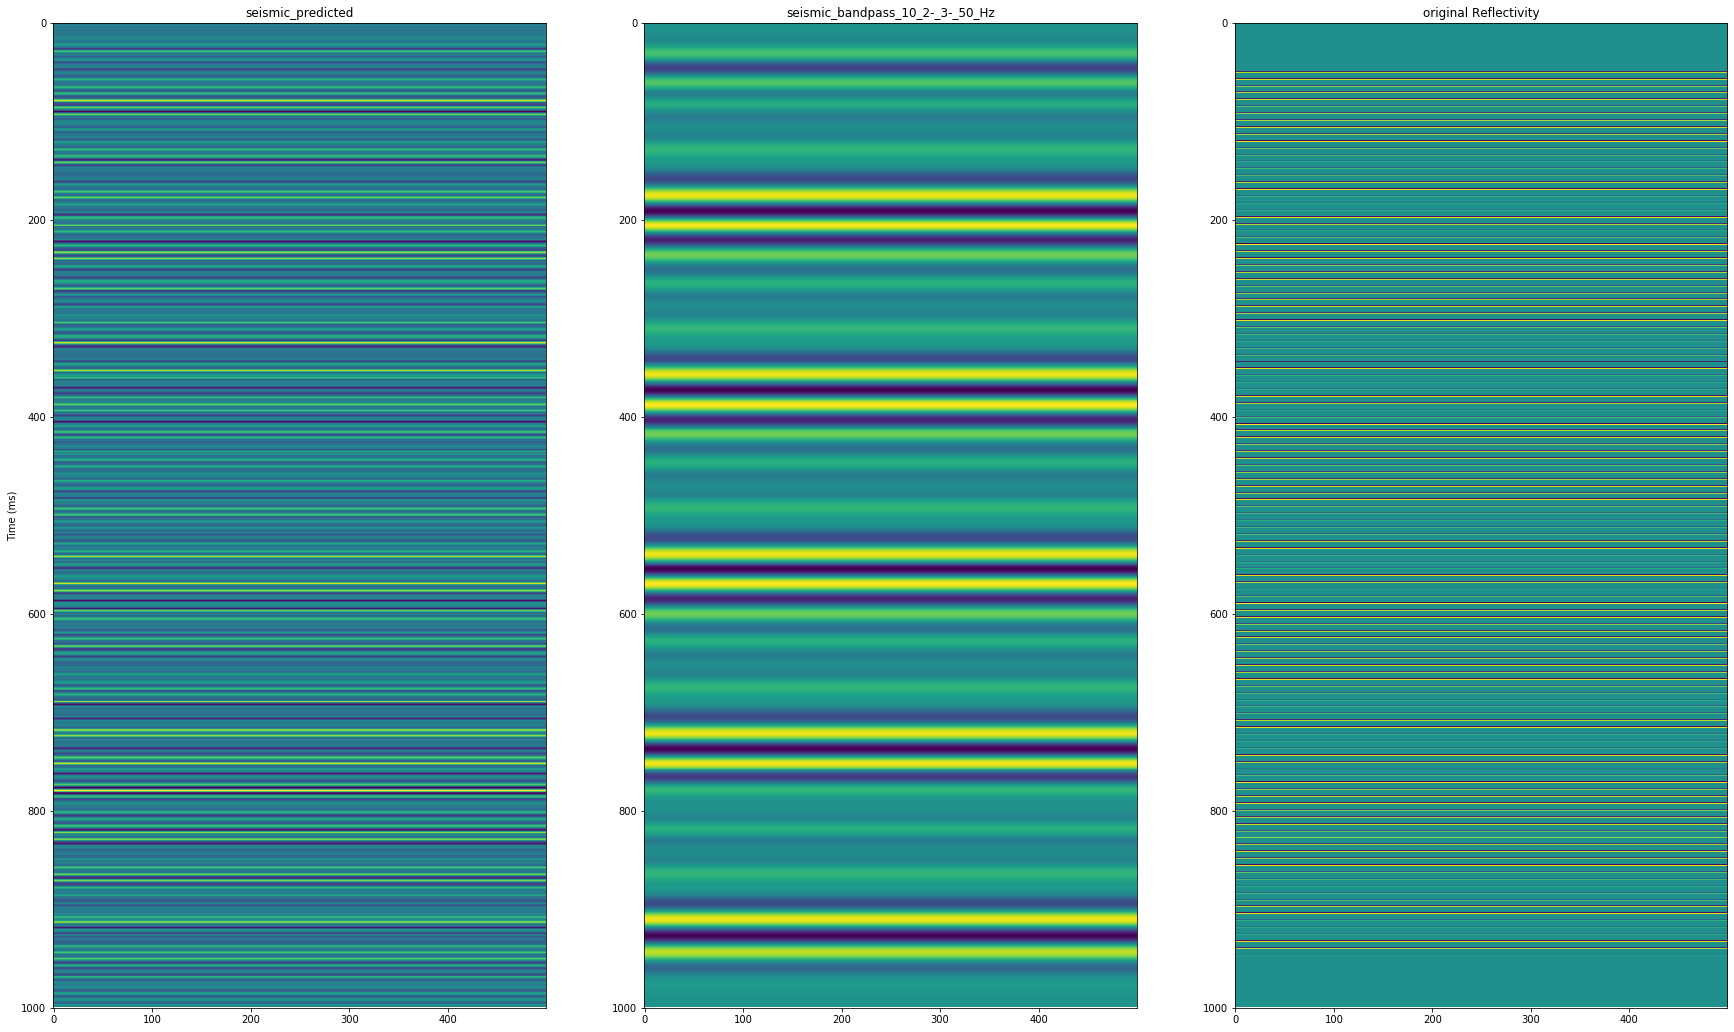

In [44]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3,figsize=(30, 60)) 
   
ax1.imshow(x_pred_sm) 
ax1.set_title('seismic_predicted')
ax1.set_ylim((0,1000)[::-1])
ax1.set_ylabel('Time (ms)')
ax2.imshow(arnold)
ax2.set_title('seismic_bandpass_10_2-_3-_50_Hz')
ax2.set_ylim((0,1000)[::-1])
ax3.imshow(ref)
ax3.set_title('original Reflectivity')
ax3.set_ylim((0,1000)[::-1])
    
plt.show()

